**Как пользоваться nbconvert**

nbconvernt моежт быть использован как утилита командной строки или же python библиотека. Тут я буду рассматривать nbconvert как python библиотеку.

In [14]:
import io

import nbformat

import matplotlib as mpl
import matplotlib.pyplot as plt

from traitlets.config import Config

from nbconvert import HTMLExporter,\
                        RSTExporter

# Источники

- https://nbconvert.readthedocs.io/en/latest/index.html - официальная документация nbconvert.
- https://nbconvert.readthedocs.io/en/latest/api/exporters.html#nbconvert.exporters.NotebookExporter - страница документации посвященная Exporters;
- https://nbconvert.readthedocs.io/en/latest/api/preprocessors.html - препроцессоры доступные по умолчанию.

# Прочитать notebook

<a id="botebooknode"></a>
Используя `nbformat.read` я могу прочесть произвольный notebook из `str`. Получается, объект типа `nbformat.notebooknode.NotebookNode`.

In [2]:
# читаю notebook как str
nbfile = open("example_notebook.ipynb", "r")
note_book_txt = nbfile.read()
nbfile.close()

# из строчки делаю nbformat.notebooknode.NotebookNode
notebook = nbformat.reads(note_book_txt, as_version=4)

Этот `nbformat.notebooknode.NotebookNode` является `dict`- подобным объектом, со следующими ключами:

In [3]:
notebook.keys()

dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])

### **`'cells'`**
Позволяет достать из объекта ячейки в текстовой форме.

Вот например ячейка с `makrdown`.

In [4]:
notebook['cells'][2]

{'cell_type': 'markdown',
 'id': '025cd9ca-bce7-4377-8a2c-d7d032b5d061',
 'metadata': {'slideshow': {'slide_type': 'fragment'}, 'tags': []},
 'source': '# Latex\n\n$$f(x) = x_2+3x+22$$'}

# Экспортировать Notebook

Можно используя exporters объекты.

Все они содержат методы позволяющие провести конвертацию:

- `from_notebook_node` - преобразует описанный [выше](#botebooknode) `nbformat.notebooknode.NotebookNode`;
- `from_file` - преобразует объект-файл (просто окрытый в python файл);
- `from_filename` - преобразует файл по имени в системе.

## *HTMLExporter*

Позволяет экспортировать файл в `html`.

In [5]:
html_exporter = HTMLExporter(template_name='classic')
(body, resources) = html_exporter.from_notebook_node(notebook)

И так возвращаяется два объекта

### **body**

Первый это тело `html` файла, его можно сразу сохранить и получается вполне себе `html`.

In [6]:
file = open("basic_html_exporter.html", "w+")
file.write(body)
file.close()

Но при спользовании такого подхода есть проблема - картинки, формируемые как часть markdown разметки не будут встроены в `.html`, а будут лишь ссылками на файлы.

### **resources**

Список ресурсов используемых для формирования jupyter.

In [7]:
resources

ResourcesDict(None,
              {'metadata': ResourcesDict(None, {'name': 'Notebook'}),
               'output_extension': '.html',
               'deprecated': <function nbconvert.exporters.templateexporter.deprecated(msg)>,
               'theme': 'light',
               'include_css': <function nbconvert.exporters.html.HTMLExporter._init_resources.<locals>.resources_include_css(name)>,
               'include_lab_theme': <function nbconvert.exporters.html.HTMLExporter._init_resources.<locals>.resources_include_lab_theme(name)>,
               'include_js': <function nbconvert.exporters.html.HTMLExporter._init_resources.<locals>.resources_include_js(name)>,
               'include_url': <function nbconvert.exporters.html.HTMLExporter._init_resources.<locals>.resources_include_url(name)>,
               'require_js_url': 'https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js',
               'mathjax_url': 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/lates

## *RSTExporter*

Позволяет диаграммы на графике экспортировать не в `.html` файл а в ресурсы.

Способ использования ничем не отличатеся от рассмотренного выше `HTMLExporter`.

In [8]:
rst_exporter = RSTExporter()
(body, resources) = rst_exporter.from_notebook_node(notebook)

Но полученный `body` содержит только текст.

In [9]:
file = open("rst_exporter.html", "w+")
file.write(body)
file.close()

Некоторые дополнительные элементы сохранены в `resources`. Так, например, картинки-результаты выполнения ячеек будут лежать `resources["outputs"]`. Далее пример их извлечения:

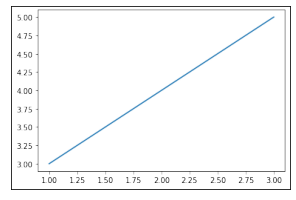

In [10]:
outputs = resources["outputs"]
outputs_len = len(outputs)

plt.figure(figsize = [5,20])
for i, pic_name in enumerate(outputs.keys()):
    plt.subplot(outputs_len, 1, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(
        plt.imread(
            io.BytesIO(outputs[pic_name]), format='jpeg'
        )
    )

Где были сохранены стили, и почему слетают способы формирования ячеек не понятно.

# Препроцессоры

Рассмотренные выше expoter-ы применяют к notebook препроцессоры - которые собвенно и занимаются обработкой notebook. Подробнее об механизме <a href=https://nbconvert.readthedocs.io/en/latest/nbconvert_library.html#Extracting-Figures-using-the-HTML-Exporter>тут</a>. Суть в ном что exporter-ы можно настраивать используя препроцессоры. nbconvert предоставляет ряд собственных препроцессоров, которые будут рассмотрены далее.

### `ExtractOutputPreprocessor`

Позволяет сохранять результаты ячеек в ресусы.

In [11]:
c = Config()
c.HTMLExporter.preprocessors = [
    'nbconvert.preprocessors.ExtractOutputPreprocessor'
]

html_exporter_with_figs = HTMLExporter(config=c)
html_exporter_with_figs.preprocessors

['nbconvert.preprocessors.ExtractOutputPreprocessor']

Сравнение результатов работы `html_exporter` без использованием препросцессора `ExtractOutputPreprocessor` и с ним.

In [12]:
(_, resources) = html_exporter.from_notebook_node(notebook)
(_, resources_with_fig) = html_exporter_with_figs.from_notebook_node(notebook)

print("resources without figures:")
print(sorted(resources.keys()))

print("\nresources with extracted figures (notice that there's one more field called 'outputs'):")
print(sorted(resources_with_fig.keys()))

print("\nthe actual figures are:")
print(sorted(resources_with_fig['outputs'].keys()))

resources without figures:
['deprecated', 'global_content_filter', 'html_manager_semver_range', 'include_css', 'include_js', 'include_lab_theme', 'include_url', 'inlining', 'jquery_url', 'jupyter_widgets_base_url', 'mathjax_url', 'metadata', 'output_extension', 'raw_mimetypes', 'require_js_url', 'theme', 'widget_renderer_url']

resources with extracted figures (notice that there's one more field called 'outputs'):
['deprecated', 'global_content_filter', 'html_manager_semver_range', 'include_css', 'include_js', 'include_lab_theme', 'include_url', 'inlining', 'jquery_url', 'jupyter_widgets_base_url', 'mathjax_url', 'metadata', 'output_extension', 'outputs', 'raw_mimetypes', 'require_js_url', 'theme', 'widget_renderer_url']

the actual figures are:
['output_4_0.png']


Как видно во втором случае в ресурсах появился ещё и ключ `'outputs'`. А по доступу к именам там содержаться результаты выполнения ячеек.

### `TagRemovePreprocessor`

Позволяет удалить input, output ячейки или всю ячейку, по выбранному тэгу.

In [20]:
from nbconvert.preprocessors import TagRemovePreprocessor

c = Config()

c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
c.TagRemovePreprocessor.enabled = True

c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
# в оригинальном примере следующая сторочка не закомментирована
# но вроде работает и без неё и не понятно, зачем она нужна
# exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

output = HTMLExporter(config=c).from_filename("example_notebook.ipynb")

file = open("TagRemovePreproc_example.html", "w+")
file.write(output[0])
file.close()

# Кастомные препроцессоры

Для создания кастомного препроцессора следует наследовать класс `nbconvert.preprocessors.Preprocessor`.

In [12]:
from traitlets import Integer
from nbconvert.preprocessors import Preprocessor


class PelicanSubCell(Preprocessor):
    """A Pelican specific preprocessor to remove some of the cells of a notebook"""

    # I could also read the cells from nb.metadata.pelican if someone wrote a JS extension,
    # but for now I'll stay with configurable value.
    start = Integer(0, help="first cell of notebook to be converted").tag(config=True)
    end = Integer(-1, help="last cell of notebook to be converted").tag(config=True)

    def preprocess(self, nb, resources):
        self.log.info("I'll keep only cells from %d to %d", self.start, self.end)
        nb.cells = nb.cells[self.start : self.end]
        return nb, resources

Затем при создании `Config` в поле `preprocessors` следует передать созданный класс. Для заполенения полей препроцессора в кофиг указываются поля по типу `<Имя класса>.<навание поля>`, как это показано ниже.

In [13]:
# Create a new config object that configures both the new preprocessor, as well as the exporter
c = Config()
c.PelicanSubCell.start = 4
c.PelicanSubCell.end = 6
c.RSTExporter.preprocessors = [PelicanSubCell]

# Create our new, customized exporter that uses our custom preprocessor
pelican = RSTExporter(config=c)

# Process the notebook
print(pelican.from_notebook_node(notebook)[0])

.. code:: ipython3

    ans = plt.plot([1,2,3], [3,4,5])



.. image:: output_4_0.png


Просто картинка



Для формирования поведения препроцессора следует переопределить методы:
- `preprocess` - для того, чтобы 

In [14]:
class My_preporcessor(Preprocessor):
    def preprocess(self, nb, resources):
        print(type(nb))
        return nb, resources
        
c = Config()
c.HTMLExporter.preprocessors = [My_preporcessor]

exporter = HTMLExporter(config = c)

a,b = exporter.from_notebook_node(notebook)

<class 'nbformat.notebooknode.NotebookNode'>
